# Comprehensive Fake News Classifier with Validation

This notebook contains a complete data analysis, training of various machine learning models for fake news classification, and validation on a separate dataset.

## Work Plan:
1. Data loading and duplicate removal
2. NLP preprocessing with creation of additional features (including bracket difference)
3. Vectorization using TF-IDF
4. Train/test split
5. Model training and comparison (RandomForest, XGBoost)
6. Best model selection and saving
7. Training on full dataset
8. Feature importance analysis
9. Predictions on validation data and saving results


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import string
from collections import Counter
import joblib
import pickle

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

# Additional libraries
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Download stopwords
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

print("Libraries successfully imported!")


Libraries successfully imported!


## 1. Data Loading and Duplicate Removal


In [ ]:
# Load data
print("Loading data...")

# Load main dataset
train_data = pd.read_csv('dataset/data.csv')
print(f"Main dataset (data.csv): {train_data.shape}")
print(f"Columns: {list(train_data.columns)}")

# Load validation data
validation_data = pd.read_csv('dataset/validation_data.csv')
print(f"Validation dataset: {validation_data.shape}")
print(f"Columns: {list(validation_data.columns)}")

# Check for duplicates in main dataset
print(f"\nDuplicates in main dataset: {train_data.duplicated().sum()}")
train_data = train_data.drop_duplicates()
print(f"Main dataset size after removing duplicates: {train_data.shape}")

# Check for required columns
required_columns = ['title', 'text', 'label']
for dataset_name, dataset in [('train_data', train_data), ('validation_data', validation_data)]:
    missing_columns = [col for col in required_columns if col not in dataset.columns]
    if missing_columns:
        print(f"❌ {dataset_name} is missing columns: {missing_columns}")
    else:
        print(f"✅ {dataset_name} has all required columns!")

print("\nFirst 3 rows of main dataset:")
print(train_data.head(3))
print("\nFirst 3 rows of validation dataset:")
print(validation_data.head(3))


Loading data...
Main dataset (data.csv): (39942, 5)
Columns: ['label', 'title', 'text', 'subject', 'date']
Validation dataset: (4956, 5)
Columns: ['label', 'title', 'text', 'subject', 'date']

Duplicates in main dataset: 201
Main dataset size after removing duplicates: (39741, 5)
✅ train_data has all required columns!
✅ validation_data has all required columns!

First 3 rows of main dataset:
   label                                              title  \
0      1  As U.S. budget fight looms, Republicans flip t...   
1      1  U.S. military to accept transgender recruits o...   
2      1  Senior U.S. Republican senator: 'Let Mr. Muell...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   

## 2. NLP Preprocessing and Additional Feature Creation


In [ ]:
# Text cleaning function
def clean_text(text):
    """Clean text from extra characters and convert to lowercase"""
    if pd.isna(text):
        return ""
    
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Remove extra characters but preserve punctuation for counting
    text = text.strip()
    
    return text

# Function to count special characters (including bracket difference)
def count_special_chars(text):
    """Count special characters in text"""
    if pd.isna(text):
        return 0, 0, 0, 0
    
    text = str(text)
    
    # Count opening brackets
    open_brackets = text.count('(') + text.count('[') + text.count('{')
    
    # Count closing brackets
    closed_brackets = text.count(')') + text.count(']') + text.count('}')
    
    # Count exclamation marks
    exclamation_marks = text.count('!')
    
    # Count question marks
    question_marks = text.count('?')
    
    return open_brackets, closed_brackets, exclamation_marks, question_marks

# Function to count characters
def count_characters(text):
    """Count number of characters in text"""
    if pd.isna(text):
        return 0
    return len(str(text))

# Function for vectorization preparation
def preprocess_for_vectorization(text):
    """Prepare text for vectorization with stopword removal"""
    if pd.isna(text) or text == "":
        return ""
    
    # Tokenization
    tokens = word_tokenize(str(text))
    
    # Get stopwords
    stop_words = set(stopwords.words('english'))
    
    # Remove stopwords and short words
    filtered_tokens = [word for word in tokens 
                      if word.lower() not in stop_words 
                      and len(word) > 2 
                      and word.isalpha()]
    
    return ' '.join(filtered_tokens)

print("✅ Text processing functions created!")


✅ Text processing functions created!


In [ ]:
# Prepare main dataset
print("Preparing main dataset (data.csv)...")

# Clean text data
print("Cleaning text data...")
train_data['title_clean'] = train_data['title'].apply(clean_text)
train_data['text_clean'] = train_data['text'].apply(clean_text)

# Create additional features
print("Creating additional features...")

# Count special characters in text
special_chars = train_data['text'].apply(count_special_chars)
train_data['open_brackets'] = [x[0] for x in special_chars]
train_data['closed_brackets'] = [x[1] for x in special_chars]
train_data['exclamation_marks'] = [x[2] for x in special_chars]
train_data['question_marks'] = [x[3] for x in special_chars]

# New feature: difference between opening and closing brackets
train_data['bracket_difference'] = train_data['open_brackets'] - train_data['closed_brackets']

# Count characters
train_data['text_char_count'] = train_data['text'].apply(count_characters)
train_data['title_char_count'] = train_data['title'].apply(count_characters)

# Prepare for vectorization
print("Preparing texts for vectorization...")
train_data['title_processed'] = train_data['title_clean'].apply(preprocess_for_vectorization)
train_data['text_processed'] = train_data['text_clean'].apply(preprocess_for_vectorization)

# Combine title and text for vectorization
train_data['combined_text'] = train_data['title_processed'] + ' ' + train_data['text_processed']

print("✅ Main dataset prepared!")
print(f"New columns: {[col for col in train_data.columns if col not in ['title', 'text', 'label', 'subject', 'date']]}")

# Statistics for new features
print("\nStatistics for new features:")
feature_cols = ['open_brackets', 'closed_brackets', 'bracket_difference', 'exclamation_marks', 'question_marks', 'text_char_count', 'title_char_count']
print(train_data[feature_cols].describe())


Preparing main dataset (data.csv)...
Cleaning text data...
Creating additional features...
Preparing texts for vectorization...
✅ Main dataset prepared!
New columns: ['title_clean', 'text_clean', 'open_brackets', 'closed_brackets', 'exclamation_marks', 'question_marks', 'bracket_difference', 'text_char_count', 'title_char_count', 'title_processed', 'text_processed', 'combined_text']

Statistics for new features:
       open_brackets  closed_brackets  bracket_difference  exclamation_marks  \
count   39741.000000     39741.000000         39741.00000       39741.000000   
mean        1.824086         1.821796             0.00229           0.412118   
std         7.067190         7.052449             0.36591           1.483599   
min         0.000000         0.000000           -16.00000           0.000000   
25%         1.000000         1.000000             0.00000           0.000000   
50%         1.000000         1.000000             0.00000           0.000000   
75%         2.000000    

In [ ]:
# Prepare validation dataset
print("Preparing validation dataset...")

# Clean text data
print("Cleaning text data...")
validation_data['title_clean'] = validation_data['title'].apply(clean_text)
validation_data['text_clean'] = validation_data['text'].apply(clean_text)

# Create additional features
print("Creating additional features...")

# Count special characters in text
special_chars_val = validation_data['text'].apply(count_special_chars)
validation_data['open_brackets'] = [x[0] for x in special_chars_val]
validation_data['closed_brackets'] = [x[1] for x in special_chars_val]
validation_data['exclamation_marks'] = [x[2] for x in special_chars_val]
validation_data['question_marks'] = [x[3] for x in special_chars_val]

# New feature: difference between opening and closing brackets
validation_data['bracket_difference'] = validation_data['open_brackets'] - validation_data['closed_brackets']

# Count characters
validation_data['text_char_count'] = validation_data['text'].apply(count_characters)
validation_data['title_char_count'] = validation_data['title'].apply(count_characters)

# Prepare for vectorization
print("Preparing texts for vectorization...")
validation_data['title_processed'] = validation_data['title_clean'].apply(preprocess_for_vectorization)
validation_data['text_processed'] = validation_data['text_clean'].apply(preprocess_for_vectorization)

# Combine title and text for vectorization
validation_data['combined_text'] = validation_data['title_processed'] + ' ' + validation_data['text_processed']

print("✅ Validation dataset prepared!")
print(f"Validation dataset size: {validation_data.shape}")

# Statistics for new features in validation
print("\nStatistics for new features (validation):")
print(validation_data[feature_cols].describe())


Preparing validation dataset...
Cleaning text data...
Creating additional features...
Preparing texts for vectorization...
✅ Validation dataset prepared!
Validation dataset size: (4956, 17)

Statistics for new features (validation):
       open_brackets  closed_brackets  bracket_difference  exclamation_marks  \
count    4956.000000      4956.000000         4956.000000        4956.000000   
mean        2.403753         2.410815           -0.007062           0.385997   
std         4.888734         4.891715            0.287216           1.239168   
min         0.000000         0.000000          -16.000000           0.000000   
25%         0.000000         0.000000            0.000000           0.000000   
50%         1.000000         1.000000            0.000000           0.000000   
75%         3.000000         3.000000            0.000000           0.000000   
max        88.000000        88.000000            1.000000          33.000000   

       question_marks  text_char_count  title_

## 3. TF-IDF Vectorization


In [ ]:
# TF-IDF vectorization
print("Applying TF-IDF vectorization...")

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Maximum number of features
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=2,  # Minimum document frequency
    max_df=0.95,  # Maximum document frequency
    stop_words='english'
)

# Apply vectorization to combined text of main dataset
tfidf_matrix = tfidf_vectorizer.fit_transform(train_data['combined_text'])

print(f"TF-IDF matrix size: {tfidf_matrix.shape}")
print(f"Number of features: {len(tfidf_vectorizer.get_feature_names_out())}")

# Create DataFrame with TF-IDF features
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=[f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])]
)

print("✅ TF-IDF vectorization completed!")


Applying TF-IDF vectorization...
TF-IDF matrix size: (39741, 5000)
Number of features: 5000
✅ TF-IDF vectorization completed!


## 4. Data Preparation for Training


In [ ]:
# Prepare features for training
print("Preparing features for training...")

# Select additional features (including new bracket_difference feature)
additional_features = ['open_brackets', 'closed_brackets', 'bracket_difference', 'exclamation_marks', 'question_marks', 'text_char_count', 'title_char_count']

# Combine TF-IDF features with additional features
X_tfidf = tfidf_df.values
X_additional = train_data[additional_features].values

# Combine all features
X_combined = np.hstack([X_tfidf, X_additional])

# Target variable
y = train_data['label'].values

print(f"Feature matrix size: {X_combined.shape}")
print(f"Target variable size: {y.shape}")
print(f"Class distribution: {np.bincount(y)}")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print("✅ Data prepared for training!")


Preparing features for training...
Feature matrix size: (39741, 5007)
Target variable size: (39741,)
Class distribution: [19940 19801]
Training set size: (31792, 5007)
Test set size: (7949, 5007)
✅ Data prepared for training!


## 5. Model Training and Comparison


In [ ]:
# Define models with different parameters (only Random Forest and XGBoost)
models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    ),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        random_state=42,
        n_jobs=-1
    )
}

print("Models defined:")
for name, model in models.items():
    print(f"- {name}: {type(model).__name__}")


Models defined:
- RandomForest: RandomForestClassifier
- XGBoost: XGBClassifier


In [ ]:
# Train and evaluate models
results = {}

print("Training and evaluating models...")
print("=" * 50)

for name, model in models.items():
    print(f"\nTraining model: {name}")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    # Save results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred
    }
    
    print(f"Test accuracy: {accuracy:.4f}")
    print(f"Cross-validation (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print("\n" + "=" * 50)
print("✅ Training of all models completed!")


Training and evaluating models...

Training model: RandomForest
Test accuracy: 0.9965
Cross-validation (mean ± std): 0.9961 ± 0.0007

Training model: XGBoost
Test accuracy: 0.9984
Cross-validation (mean ± std): 0.9974 ± 0.0012

✅ Training of all models completed!


## 6. Confusion Matrices and Model Comparison


In [ ]:
# Create comparison table of results
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test_Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'CV_Mean': [results[name]['cv_mean'] for name in results.keys()],
    'CV_Std': [results[name]['cv_std'] for name in results.keys()]
})

# Sort by test accuracy
results_df = results_df.sort_values('Test_Accuracy', ascending=False)

print("Model comparison results:")
print("=" * 60)
print(results_df.to_string(index=False, float_format='%.4f'))

# Select best model
best_model_name = results_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_accuracy = results_df.iloc[0]['Test_Accuracy']

print(f"\n🏆 Best model: {best_model_name}")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Model type: {type(best_model).__name__}")

# Detailed report for best model
print(f"\nDetailed report for {best_model_name}:")
print("=" * 40)
y_pred_best = results[best_model_name]['predictions']
print(classification_report(y_test, y_pred_best))


Model comparison results:
       Model  Test_Accuracy  CV_Mean  CV_Std
     XGBoost         0.9984   0.9974  0.0012
RandomForest         0.9965   0.9961  0.0007

🏆 Best model: XGBoost
Accuracy: 0.9984
Model type: XGBClassifier

Detailed report for XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3988
           1       1.00      1.00      1.00      3961

    accuracy                           1.00      7949
   macro avg       1.00      1.00      1.00      7949
weighted avg       1.00      1.00      1.00      7949



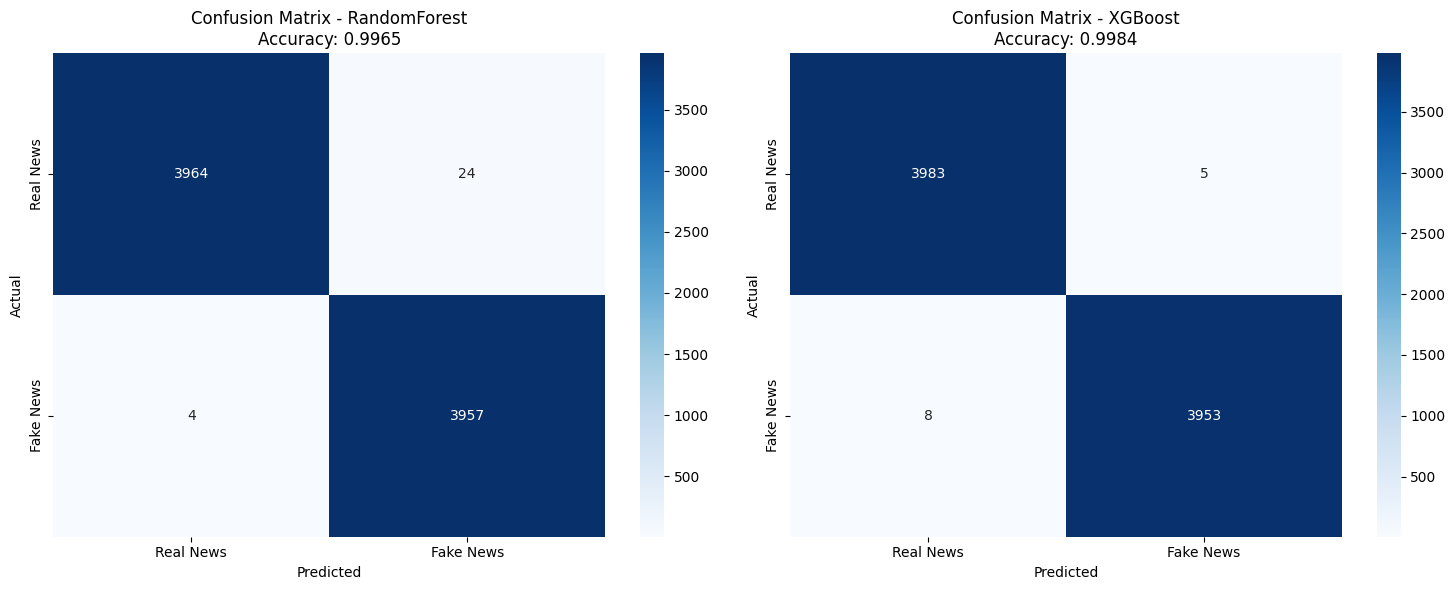

Confusion Matrix Details:

RandomForest:
True Negatives (Real News correctly classified): 3964
False Positives (Real News misclassified as Fake): 24
False Negatives (Fake News misclassified as Real): 4
True Positives (Fake News correctly classified): 3957
Precision: 0.9940
Recall: 0.9990
F1-Score: 0.9965

XGBoost:
True Negatives (Real News correctly classified): 3983
False Positives (Real News misclassified as Fake): 5
False Negatives (Fake News misclassified as Real): 8
True Positives (Fake News correctly classified): 3953
Precision: 0.9987
Recall: 0.9980
F1-Score: 0.9984


In [ ]:
# Create confusion matrices for both models
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, (name, result) in enumerate(results.items()):
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, result['predictions'])
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {name}\nAccuracy: {result["accuracy"]:.4f}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    
    # Add class labels
    axes[i].set_xticklabels(['Real News', 'Fake News'])
    axes[i].set_yticklabels(['Real News', 'Fake News'])

plt.tight_layout()
plt.show()

# Print confusion matrix details
print("Confusion Matrix Details:")
print("=" * 50)
for name, result in results.items():
    cm = confusion_matrix(y_test, result['predictions'])
    print(f"\n{name}:")
    print(f"True Negatives (Real News correctly classified): {cm[0,0]}")
    print(f"False Positives (Real News misclassified as Fake): {cm[0,1]}")
    print(f"False Negatives (Fake News misclassified as Real): {cm[1,0]}")
    print(f"True Positives (Fake News correctly classified): {cm[1,1]}")
    
    # Calculate additional metrics
    precision = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
    recall = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")


## 7. Training on Full Dataset


In [ ]:
# Train best model on full dataset
print(f"Training best model ({best_model_name}) on full dataset...")

# Prepare full dataset
X_full = X_combined
y_full = y

print(f"Full feature matrix size: {X_full.shape}")
print(f"Target variable size: {y_full.shape}")
print(f"Class distribution: {np.bincount(y_full)}")

# Create new model with same parameters
if best_model_name == 'XGBoost':
    full_model = xgb.XGBClassifier(**best_model.get_params())
else:
    full_model = RandomForestClassifier(**best_model.get_params())

# Train model on full dataset
print("Training model...")
full_model.fit(X_full, y_full)

print("✅ Model trained on full dataset!")


Training best model (XGBoost) on full dataset...
Full feature matrix size: (39741, 5007)
Target variable size: (39741,)
Class distribution: [19940 19801]
Training model...
✅ Model trained on full dataset!


## 8. Feature Importance Analysis


Feature importance analysis...
Top-20 most important features:
               feature  importance
3757        tfidf_3757    0.458675
5000     open_brackets    0.008268
1576        tfidf_1576    0.005496
411          tfidf_411    0.005359
2419        tfidf_2419    0.005231
1952        tfidf_1952    0.004854
3761        tfidf_3761    0.004222
1830        tfidf_1830    0.004162
1886        tfidf_1886    0.004020
2292        tfidf_2292    0.003933
3959        tfidf_3959    0.003515
1623        tfidf_1623    0.003495
65            tfidf_65    0.003129
412          tfidf_412    0.003011
5006  title_char_count    0.002945
3477        tfidf_3477    0.002854
3487        tfidf_3487    0.002835
4995        tfidf_4995    0.002822
1729        tfidf_1729    0.002754
2949        tfidf_2949    0.002634

Importance of additional features:
                 feature  importance
5000       open_brackets    0.008268
5006    title_char_count    0.002945
5004      question_marks    0.001684
5003   exclamation

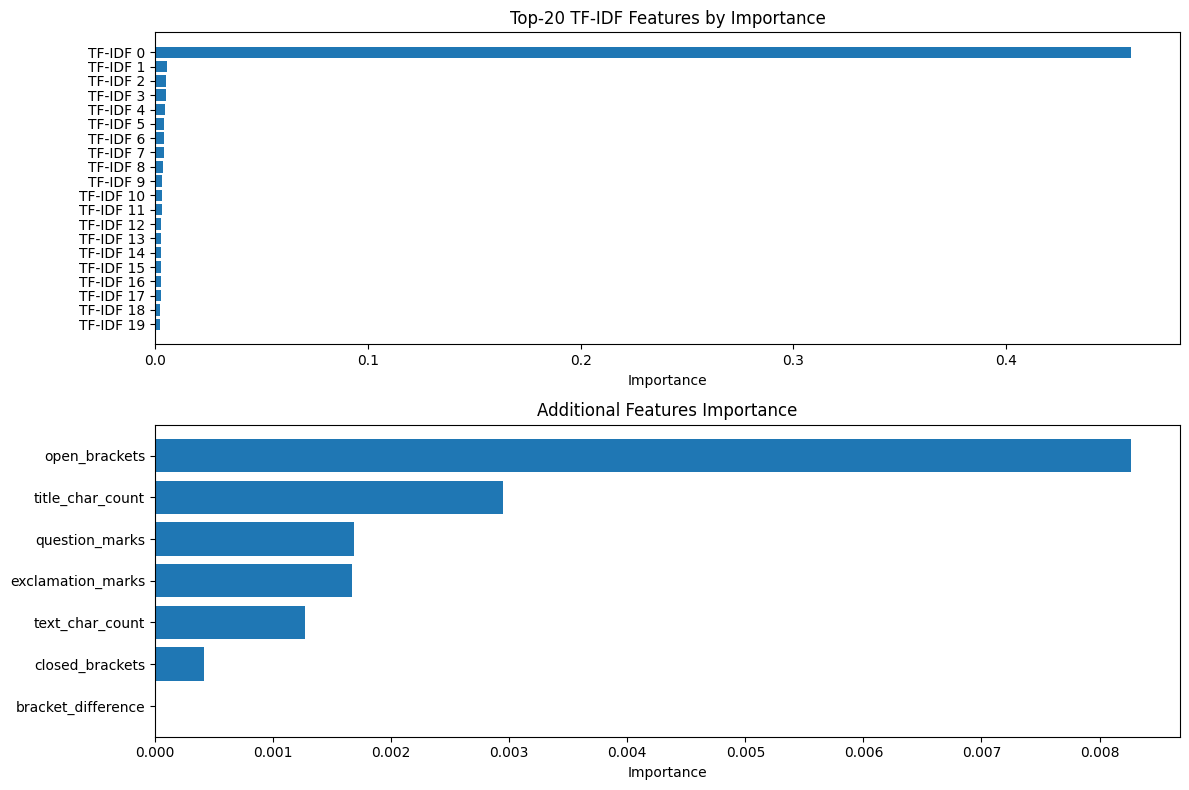

✅ Feature importance analysis completed!


In [ ]:
# Feature importance analysis
print("Feature importance analysis...")

# Get feature importance
feature_importance = full_model.feature_importances_

# Create list of feature names
tfidf_feature_names = [f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])]
all_feature_names = tfidf_feature_names + additional_features

# Create DataFrame with feature importance
importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top-20 most important features:")
print(importance_df.head(20))

# Analyze importance of additional features
print(f"\nImportance of additional features:")
additional_importance = importance_df[importance_df['feature'].isin(additional_features)]
print(additional_importance)

# Visualize feature importance
plt.figure(figsize=(12, 8))

# Top-20 TF-IDF features
top_tfidf = importance_df[importance_df['feature'].str.startswith('tfidf_')].head(20)
plt.subplot(2, 1, 1)
plt.barh(range(len(top_tfidf)), top_tfidf['importance'])
plt.yticks(range(len(top_tfidf)), [f"TF-IDF {i}" for i in range(len(top_tfidf))])
plt.xlabel('Importance')
plt.title('Top-20 TF-IDF Features by Importance')
plt.gca().invert_yaxis()

# Additional features
plt.subplot(2, 1, 2)
plt.barh(range(len(additional_importance)), additional_importance['importance'])
plt.yticks(range(len(additional_importance)), additional_importance['feature'])
plt.xlabel('Importance')
plt.title('Additional Features Importance')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

print("✅ Feature importance analysis completed!")


## 9. Validation Data Predictions


In [ ]:
# Prepare validation data for predictions
print("Preparing validation data for predictions...")

# Apply TF-IDF vectorization to validation data
print("Applying TF-IDF vectorization to validation data...")
tfidf_matrix_val = tfidf_vectorizer.transform(validation_data['combined_text'])

print(f"TF-IDF matrix size for validation: {tfidf_matrix_val.shape}")

# Create DataFrame with TF-IDF features for validation
tfidf_df_val = pd.DataFrame(
    tfidf_matrix_val.toarray(),
    columns=[f'tfidf_{i}' for i in range(tfidf_matrix_val.shape[1])]
)

# Prepare features for validation
X_tfidf_val = tfidf_df_val.values
X_additional_val = validation_data[additional_features].values

# Combine all features for validation
X_combined_val = np.hstack([X_tfidf_val, X_additional_val])

print(f"Feature matrix size for validation: {X_combined_val.shape}")

# Check size compatibility
if X_combined_val.shape[1] != X_combined.shape[1]:
    print(f"⚠️  Warning: Feature sizes don't match!")
    print(f"Training data: {X_combined.shape[1]} features")
    print(f"Validation data: {X_combined_val.shape[1]} features")
else:
    print("✅ Feature sizes match!")

print("✅ Validation data prepared for predictions!")


Preparing validation data for predictions...
Applying TF-IDF vectorization to validation data...
TF-IDF matrix size for validation: (4956, 5000)
Feature matrix size for validation: (4956, 5007)
✅ Feature sizes match!
✅ Validation data prepared for predictions!


In [ ]:
# Make predictions on validation data
print("Making predictions on validation data...")

# Predictions
predictions = full_model.predict(X_combined_val)
prediction_proba = full_model.predict_proba(X_combined_val)

print(f"Number of predictions: {len(predictions)}")
print(f"Predicted class distribution: {np.bincount(predictions)}")

# Create copy of validation data with predictions
validation_labeled = validation_data.copy()
validation_labeled['label'] = predictions
validation_labeled['prediction_proba_0'] = prediction_proba[:, 0]
validation_labeled['prediction_proba_1'] = prediction_proba[:, 1]

print("✅ Predictions completed!")
print(f"Final dataset size: {validation_labeled.shape}")

# Show prediction examples
print("\nPrediction examples:")
sample_predictions = validation_labeled[['title', 'text', 'label', 'prediction_proba_0', 'prediction_proba_1']].head(10)
print(sample_predictions)


Making predictions on validation data...
Number of predictions: 4956
Predicted class distribution: [3501 1455]
✅ Predictions completed!
Final dataset size: (4956, 19)

Prediction examples:
                                               title  \
0  UK's May 'receiving regular updates' on London...   
1  UK transport police leading investigation of L...   
2  Pacific nations crack down on North Korean shi...   
3  Three suspected al Qaeda militants killed in Y...   
4  Chinese academics prod Beijing to consider Nor...   
5  Flames raced along train at west London statio...   
6  London police advise people to avoid area near...   
7  London ambulance service sends hazardous area ...   
8  Witness says injured in stampede at London sta...   
9  UK says world will stand together against Nort...   

                                                text  label  \
0  LONDON (Reuters) - British Prime Minister Ther...      1   
1  LONDON (Reuters) - British counter-terrorism p...      1   
2  WE

## 10. Save Results


In [ ]:
# Save best model and necessary components
print(f"Saving best model: {best_model_name}")

# Create dictionary with model and components
model_package = {
    'model': full_model,
    'tfidf_vectorizer': tfidf_vectorizer,
    'model_name': best_model_name,
    'accuracy': best_accuracy,
    'feature_names': additional_features,
    'preprocessing_functions': {
        'clean_text': clean_text,
        'count_special_chars': count_special_chars,
        'count_characters': count_characters,
        'preprocess_for_vectorization': preprocess_for_vectorization
    }
}

# Save model
model_filename = f'best_fake_news_classifier_{best_model_name.lower()}.pkl'
joblib.dump(model_package, model_filename)

print(f"✅ Model saved to file: {model_filename}")

# Create model information file
model_info = f"""
Information about saved model:
================================
Model name: {best_model_name}
Model type: {type(full_model).__name__}
Test accuracy: {best_accuracy:.4f}
Creation date: {pd.Timestamp.now()}

Model parameters:
{full_model.get_params()}

Used features:
- TF-IDF vectorization (5000 features)
- Number of opening brackets
- Number of closing brackets
- Difference between opening and closing brackets (NEW FEATURE)
- Number of exclamation marks  
- Number of question marks
- Number of characters in text
- Number of characters in title

Model file: {model_filename}
"""

with open('model_info.txt', 'w', encoding='utf-8') as f:
    f.write(model_info)

print("✅ Model information saved to model_info.txt")
print(f"\nModel ready for use! File: {model_filename}")


Saving best model: XGBoost
✅ Model saved to file: best_fake_news_classifier_xgboost.pkl
✅ Model information saved to model_info.txt

Model ready for use! File: best_fake_news_classifier_xgboost.pkl


In [ ]:
# Save validation results
print("Saving validation results...")

# Save validation data with predictions in correct format
output_filename = f'dataset/validation_{best_model_name}_labeled_data.csv'

# Create final dataset with predictions, keeping only necessary columns
final_validation_data = validation_data[['label', 'title', 'text', 'subject', 'date']].copy()
final_validation_data['label'] = predictions  # Replace original labels with predictions

final_validation_data.to_csv(output_filename, index=False)

print(f"✅ Validation data with predictions saved to file: {output_filename}")

# Save feature importance information
importance_filename = 'feature_importance_analysis.csv'
importance_df.to_csv(importance_filename, index=False)

print(f"✅ Feature importance analysis saved to file: {importance_filename}")

# Create summary report
summary_report = f"""
Report on training {best_model_name} model on full dataset
==================================================

Creation date: {pd.Timestamp.now()}

Data:
- Main dataset (data.csv): {train_data.shape[0]} records
- Validation dataset: {validation_data.shape[0]} records
- Number of features: {X_combined.shape[1]}

Model:
- Type: {type(full_model).__name__}
- Parameters: {full_model.get_params()}

Results:
- Number of predictions: {len(predictions)}
- Class distribution: {dict(zip(*np.unique(predictions, return_counts=True)))}

New features:
- Added 'bracket_difference' feature (difference between opening and closing brackets)

Files:
- Validation with predictions: {output_filename}
- Feature importance analysis: {importance_filename}
- Model: {model_filename}

Top-5 most important features:
{importance_df.head(5).to_string(index=False)}
"""

# Save report
with open(f'{best_model_name}_training_report.txt', 'w', encoding='utf-8') as f:
    f.write(summary_report)

print(f"✅ Summary report saved to file: {best_model_name}_training_report.txt")

print("\n" + "="*60)
print("🎉 ALL TASKS COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"📁 Main result: {output_filename}")
print(f"📊 Feature analysis: {importance_filename}")
print(f"🤖 Model: {model_filename}")
print(f"📋 Report: {best_model_name}_training_report.txt")
print("="*60)


Saving validation results...
✅ Validation data with predictions saved to file: dataset/validation_XGBoost_labeled_data.csv
✅ Feature importance analysis saved to file: feature_importance_analysis.csv
✅ Summary report saved to file: XGBoost_training_report.txt

🎉 ALL TASKS COMPLETED SUCCESSFULLY!
📁 Main result: dataset/validation_XGBoost_labeled_data.csv
📊 Feature analysis: feature_importance_analysis.csv
🤖 Model: best_fake_news_classifier_xgboost.pkl
📋 Report: XGBoost_training_report.txt
